In [1]:
# Imports

#pandas
import pandas as pd


#numpy, matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn import cross_validation as cross_v
import xgboost as xgb

/Users/EdouM/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


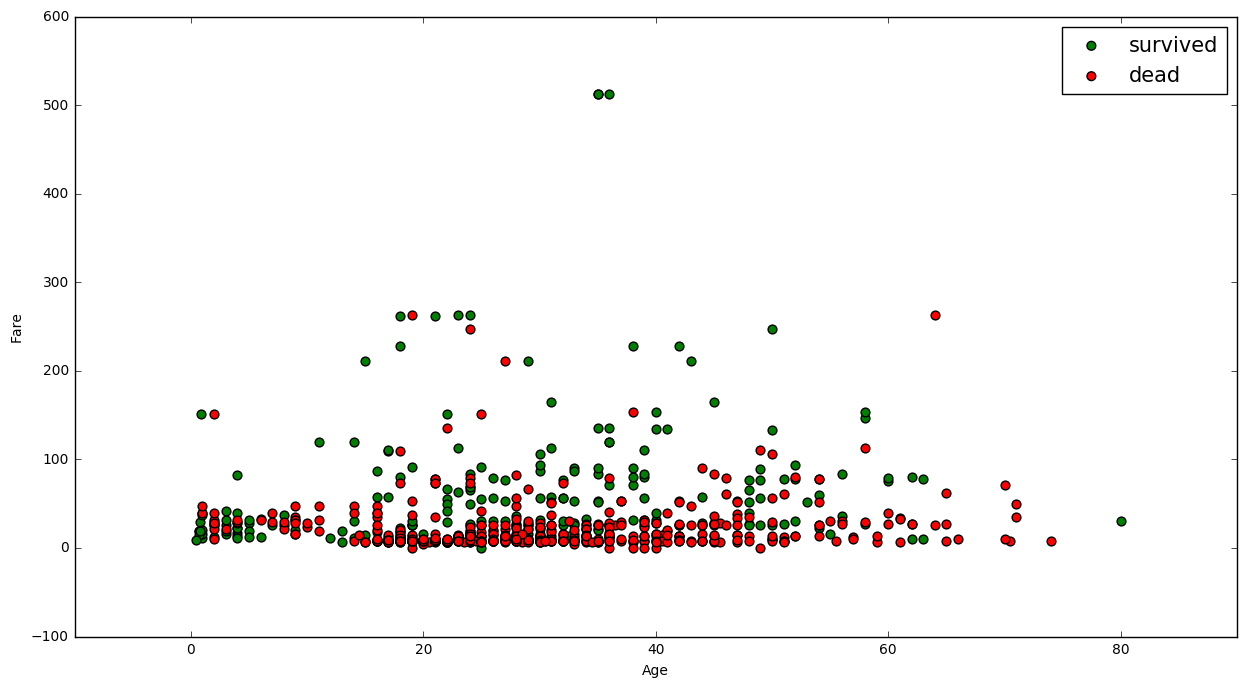

In [2]:
#Get the data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")



#Data visualization on the train
plt.figure(figsize=(15,8))
ax = plt.subplot()
ax.scatter(train[train['Survived']==1]['Age'],train[train['Survived']==1]['Fare'],c='green',s=40)
ax.scatter(train[train['Survived']==0]['Age'],train[train['Survived']==0]['Fare'],c='red',s=40)
ax.set_xlabel('Age')
ax.set_ylabel('Fare')
ax.legend(('survived','dead'),scatterpoints=1,loc='upper right',fontsize=15,)



In [3]:
#Combine the data
targets = train.Survived
train.drop('Survived', axis = 1,inplace = True)

data = train.append(test)
data.reset_index(inplace=True)
data.drop('index',inplace = True,axis = 1)



In [4]:
#Let's map the sex to 0 and 1 (0 for Women, 1 for Men) to be able to take that data into account, in a new column called Gender
data['Gender'] = data['Sex'].map({'female': 0,'male':1})

In [5]:
#Fill in the missing values - let's start with Embarked, because we only have 2 missing values
#print (titanic_df.Embarked.value_counts())

#The most frequent value is 'S', so we'll just fill in the missing values with 'S'
data.Embarked = data.Embarked.fillna('S')

#Create the dummies for Embarked
data = pd.concat([data,pd.get_dummies(data.Embarked, prefix = "Embarked")], axis=1)

In [6]:
#Create dummies for the Pclass:
data = pd.concat([data,pd.get_dummies(data.Pclass, prefix='Class')],axis=1)

In [7]:
#The other missing value is age. To do this, let's fill in the missing ages with the median ages of each gender in each class to be as accurante as possible.
median_ages = np.zeros((2,3))
for i in range(0,2):
    for j in range(0,3):
        median_ages[i,j] = data[(data.Gender == i) & (data.Pclass == j+1)].Age.dropna().median()
        
#Now let's create a new age column and fill in the missing data with the according mean
data['Agefill'] = data['Age']
for i in range(0,2):
    for j in range(0,3):
        data.loc[(data.Age.isnull())&(data.Gender == i)& (data.Pclass ==j+1), 'Agefill'] = median_ages[i,j]
        
#We also need to fill in that on Fare value that's missing. The fare seems to depend on the Pclass, so we're gonna calculate the median for each class and then fill in with the right data
median_fares = np.zeros((1,3))

for i in range(0,3):
    median_fares[0,i] = data[data.Pclass == i+1].Fare.median()

    
#We just need to fill in the missing fare with the right value
for i in range(0,3):
    data.loc[(data.Fare.isnull())&(data.Pclass == i+1),'Fare'] = median_fares[0,i]


In [8]:
#Feature engineering : We'll create a family size, and multiply Age and Class together because they both seem to have an impact on the survival rate
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

data['Singleton']=data['FamilySize'].map(lambda x: 1 if x==1 else 0)
data['SmallFamily']=data.FamilySize.map(lambda x:1 if 2<=x<=4 else 0)
data['LargeFamily']=data.FamilySize.map(lambda x:1 if x>4 else 0)

data['Age*Class'] = data['Agefill']*data['Pclass']



#titanic_df['Age*Class'].hist(bins = 10)

In [9]:
#Feature engineering round 2 : title
import re
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.',name)
    if title_search:
        return title_search.group(1)
    return ''

titles = data.Name.apply(get_title)
title_dic = {
                        "Capt":       "Officer",
                        "Col":        "Officer",
                        "Major":      "Officer",
                        "Jonkheer":   "Royalty",
                        "Don":        "Royalty",
                        "Sir" :       "Royalty",
                        "Dr":         "Officer",
                        "Rev":        "Officer",
                        "the Countess":"Royalty",
                        "Dona":       "Royalty",
                        "Mme":        "Mrs",
                        "Mlle":       "Miss",
                        "Ms":         "Mrs",
                        "Mr" :        "Mr",
                        "Mrs" :       "Mrs",
                        "Miss" :      "Miss",
                        "Master" :    "Master",
                        "Lady" :      "Royalty"

                        }
data['title_group']=titles.map(title_dic)
data = pd.concat([data,pd.get_dummies(data.title_group, prefix='Title')], axis=1)


In [10]:
#Final preparation : we only want to keep the numerical values
#print data.dtypes

In [11]:
#We drop the "object" values, and the 'Age' column because we now have Agefill
data = data.drop(['Name','Sex','Ticket','Cabin','Embarked','title_group','Pclass','Age'],axis=1)

In [12]:
#Feature scaling
features = list(data.columns)
features.remove('PassengerId')
data[features]=data[features].apply(lambda x : x/x.max(),axis=0)

In [13]:
#We will now pass our training examples in the model
X_train = data.drop(['PassengerId'], axis = 1).ix[0:890]
Y_train = targets
X_test = data.drop(['PassengerId'],axis = 1).ix[891:]

#We will store the different scores in a dictionnary
scoredic = {}

#We prepare a 3 folds validation 
kf = cross_v.KFold(X_train.shape[0], n_folds=5, random_state = 1)

/Users/EdouM/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


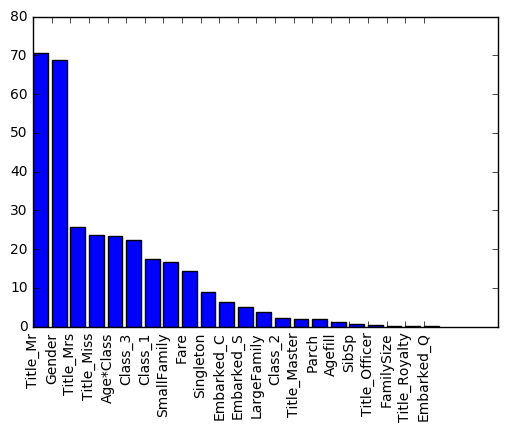

In [14]:
#See the best features
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=10)
selector.fit(X_train,Y_train)
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = -np.log10(selector.pvalues_)
#Let's sort the different features according to their importance
features.sort(['importance'],ascending=False, inplace= True)
features.reset_index(inplace=True)
features.drop('index',inplace = True,axis = 1)

plt.bar(range(len(features.feature)), features.importance)
plt.xticks(range(len(features.feature)), features.feature, rotation='vertical')
plt.show()

In [15]:
#Logistic regression
logreg = LogisticRegression()
logreg.fit(X_train,Y_train)
scoredic['logscore'] = logreg.score(X_train,Y_train)
scores = cross_v.cross_val_score(logreg, X_train, Y_train, cv=kf)


In [16]:
#Support vector machines
svc = SVC()

svc.fit(X_train,Y_train)
scoredic['svcscore'] = svc.score(X_train,Y_train)
scores = cross_v.cross_val_score(svc, X_train, Y_train, cv=kf)
print scores

[ 0.84357542  0.82022472  0.81460674  0.79213483  0.85955056]


In [17]:
#Random Forests
from sklearn.grid_search import GridSearchCV
random_forest = RandomForestClassifier(max_features='sqrt')


parameter_grid = {
    'max_depth' : [4,5,6,7,8],
    'n_estimators' : [50,100,150,200,250],
    'criterion' : ['gini', 'entropy']
                }

print('Training..')
grid_search = GridSearchCV(random_forest, param_grid=parameter_grid, cv=kf)

grid_search.fit(X_train,Y_train)

print('Done.')
print ('Best score: {}'.format(grid_search.best_score_))
print ('Best parameters: {}'.format(grid_search.best_params_))
random_forest.fit(X_train,Y_train)
#scoredic['rfscore'] = random_forest.score(X_train,Y_train)
#scores = cross_validation.cross_val_score(random_forest, X_train, Y_train, cv=kf)
#print scores




Training..


/Users/EdouM/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Done.
Best score: 0.833894500561
Best parameters: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 4}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [18]:
#KNN

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train,Y_train)
scoredic['knnscore'] = knn.score(X_train,Y_train)
scores = cross_v.cross_val_score(knn, X_train, Y_train, cv=kf)
print scores

[ 0.77653631  0.79213483  0.83707865  0.76404494  0.84269663]


In [19]:
#XGBoost
xg = xgb.XGBClassifier(max_depth = 3, n_estimators = 300, learning_rate = 0.05)
xg.fit(X_train,Y_train)
scoredic['xgboost'] = xg.score(X_train,Y_train)
scores = cross_v.cross_val_score(xg, X_train, Y_train, cv=kf)
print scores

[ 0.81005587  0.84269663  0.85955056  0.82022472  0.87078652]


In [20]:
#We print the algorithm with the best score
#print scoredic
print max(scoredic, key=scoredic.get), " : " , scoredic[max(scoredic, key=scoredic.get)]

xgboost  :  0.890011223345


In [21]:
#Logistic regression
Y_pred_log = logreg.predict(X_test)

In [22]:
#SVM
Y_pred_svm = svc.predict(X_test)

In [23]:
#Random forests 
Y_pred_rf = random_forest.predict(X_test)
Y_pred = grid_search.predict(X_test).astype(int)

In [24]:
#Knn
Y_pred_knn = knn.predict(X_test)

In [25]:
#XGBoost
Y_pred_xg = xg.predict(X_test)

In [26]:
#Submit the results
submission = pd.DataFrame({
        'PassengerId':test['PassengerId'],
        'Survived' : Y_pred
    })
submission.to_csv('titanic.csv',index=False)

In [27]:
print('done')

done
